In [1]:
import numpy as np
import os
import warnings
import pandas as pd
import scipy.interpolate as scintrp
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from scipy.signal import savgol_filter as smooth

# import sys
# sys.path.append(r'D:/OneDrive - The University of Western Ontario/Documents/PhD/Thesis/CodeRepositories/windCalc/src')
import foamDataHandler as foam
import windLoadCaseProcessors as wProc
import windPlotters as wPlt
import windBasics as wind


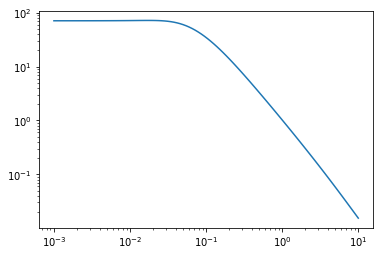

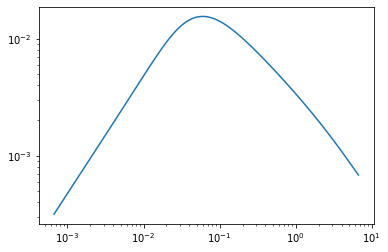

In [2]:
es = wind.ESDU85(z0=0.3,Uref=15)
# print(es.xLu())
nn = np.logspace(-3,1,100)
n, Svv = es.Svv(n=nn)
rf, rSvv = es.rSvv(n=nn)


plt.figure()
plt.loglog(n, Svv)

plt.figure()
plt.loglog(rf, rSvv)



# Inflow scaling

In [ ]:
caseDir = "D:/tempData_depot/simData_CandC/tngE2/"
wtFile = caseDir+"tngE2Fr1_profile.csv"
vwtOrigFile = caseDir+"vwtO15orig.csv"

H = 0.08

target = wind.profile(name="BLWT",fileName=wtFile,H=H)
# vwtOrig = wind.profile(name="VWT_orig",fileName=vwtOrigFile,H=H)

# profs = wind.Profiles((target,vwtOrig))
# profs.plotProfiles(
#                     figSize=[15,5],
#                     normalize=False,
#                     xLimits=[[0,20],[0,0.4],[0,0.35],[0,0.15]],
#                     zLimits=[0,2.3])



In [ ]:
dt = 3.7890e-04

file = caseDir+"tngE2Fr1_TH-UofT.csv"
U_TH = np.transpose((pd.read_csv(file)).to_numpy())
file = caseDir+"tngE2Fr1_TH-VofT.csv"
V_TH = np.transpose((pd.read_csv(file)).to_numpy())
file = caseDir+"tngE2Fr1_TH-WofT.csv"
W_TH = np.transpose((pd.read_csv(file)).to_numpy())




In [ ]:
target = wind.profile(name="BLWT-E2", Z=target.Z,UofT=U_TH,VofT=V_TH,WofT=W_TH,H=H,dt=dt,nSpectAvg=64)



In [ ]:
# vwtOrig = foam.processVelProfile(
#                         caseDir='D:/tempData_depot/simData_CandC/ttuPSpcOP15.7', 
#                         probeName='probes.x0y0', 
#                         name='VWTorig',
#                         targetProfile=None,
#                         normalize=True,
#                         H=H,
#                         writeToDataFile=True,
#                         trimTimeSegs=[[0,0.5]],
#                         showPlots=True,
#                         exportPlots=True)[0]

# vwtOrig.nSpectAvg = 64
# vwtOrig.reAnalyze()

## Iteration 1

### Calibrate the scaling factors

In [ ]:
# factorFile = caseDir+"tngE2_infScalingFactor_v0.csv"
# Z = np.sort(np.concatenate((target.Z[2:],vwtOrig.Z[1:-10])))

# intrp_U_wt = scintrp.interp1d(target.Z, target.U, fill_value='extrapolate')
# intrp_Iu_wt = scintrp.interp1d(target.Z, target.Iu, fill_value='extrapolate')
# intrp_Iv_wt = scintrp.interp1d(target.Z, target.Iv, fill_value='extrapolate')
# intrp_Iw_wt = scintrp.interp1d(target.Z, target.Iw, fill_value='extrapolate')

# intrp_U_vwt = scintrp.interp1d(vwtOrig.Z, vwtOrig.U, fill_value='extrapolate')
# intrp_Iu_vwt = scintrp.interp1d(vwtOrig.Z, vwtOrig.Iu, fill_value='extrapolate')
# intrp_Iv_vwt = scintrp.interp1d(vwtOrig.Z, vwtOrig.Iv, fill_value='extrapolate')
# intrp_Iw_vwt = scintrp.interp1d(vwtOrig.Z, vwtOrig.Iw, fill_value='extrapolate')

# fU_0 = smooth(np.divide(intrp_U_wt(Z), intrp_U_vwt(Z)),15,3)
# fIu_0 = smooth(np.divide(intrp_Iu_wt(Z), intrp_Iu_vwt(Z)),15,3)
# fIv_0 = smooth(np.divide(intrp_Iv_wt(Z), intrp_Iv_vwt(Z)),15,3)
# fIw_0 = smooth(np.divide(intrp_Iw_wt(Z), intrp_Iw_vwt(Z)),15,3)

# data = pd.DataFrame(np.stack((Z,fU_0,fIu_0,fIv_0,fIw_0),axis=-1),columns=["Z","U","Iu","Iv","Iw"])

# # data.to_csv(factorFile,index=False)

# plt.figure(figsize=[10,6])
# plt.subplot(1,2,1)
# plt.plot(fIu_0,Z)

# plt.subplot(1,2,2)
# plt.plot(intrp_Iu_wt(Z),Z,label="BLWT")
# plt.plot(np.multiply(intrp_Iu_vwt(Z),fIu_0),Z,label="VWT-scaled")
# plt.legend()
# plt.show()

### Check scaled inflow data

In [ ]:
bData = "boundaryData_v1.0"
tRanges = ( ("0.0","5.0"),
            ("10.0","15.0"),
            ("30.0","35.0"),
            ("15.0","70.0"),
            ("64.0","65.0"),
            ("65.0","70.0"))
U = None
for t in tRanges:
    fileU = caseDir+"constant/"+bData+"/Scaled_"+t[0]+"_to_"+t[1]+"_U-TH.npy"
    fileV = caseDir+"constant/"+bData+"/Scaled_"+t[0]+"_to_"+t[1]+"_V-TH.npy"
    fileW = caseDir+"constant/"+bData+"/Scaled_"+t[0]+"_to_"+t[1]+"_W-TH.npy"
    if U is None:
        U = np.load(fileU)
        V = np.load(fileV)
        W = np.load(fileW)
    else:
        U = np.concatenate((U,np.load(fileU)),axis=1)
        V = np.concatenate((V,np.load(fileV)),axis=1)
        W = np.concatenate((W,np.load(fileW)),axis=1)

file = caseDir+"constant/"+bData+"/Scaled_"+tRanges[0][0]+"_to_"+tRanges[0][1]+"_profiles.csv"
prfl = pd.read_csv(file)

e = -1 #6500

scaled_v1 = wind.profile(name="Infl-v1", Z=prfl.Z,UofT=U[:,0:e],VofT=V[:,0:e],WofT=W[:,0:e],H=H,dt=0.001)

profs = wind.Profiles((target,scaled_v1))

profs.plotProfiles(
                    figSize=[20,6],
                    normalize=True,
                    xLimits=[[0,2],[0,0.4],[0,0.35],[0,0.15]],
                    zLimits=[0,20])

# scaled_v1_0.plotTimeHistory(figSize=[20,3],xLimits=[0,8],xLabel='$t^*$',dataLabels=r'$x=\frac{ax^2}{2y^2}$',figFile=caseDir+"test.pdf",alwaysShowFig=True)


### Check empty domain simulation

In [ ]:

emtyCD_CaseDir = "D:/tempData_depot/simData_CandC/tngE2empV0/"

file = emtyCD_CaseDir+"_processed/tngE2empV0__U-TH.npy"
U = np.load(file)
file = emtyCD_CaseDir+"_processed/tngE2empV0__V-TH.npy"
V = np.load(file)
file = emtyCD_CaseDir+"_processed/tngE2empV0__W-TH.npy"
W = np.load(file)

file = emtyCD_CaseDir+"_processed/tngE2empV0__profiles.csv"
prfl = pd.read_csv(file)

LES_E2v0 = wind.profile(name="LES-E2v0", Z=prfl.Z,UofT=U,VofT=V,WofT=W,H=H,dt=0.0002,nSpectAvg=32)

# LES_E2v0 = foam.processVelProfile(
#                         caseDir='D:/tempData_depot/simData_CandC/tngE2empV0/', 
#                         probeName='sampler.zProfile_x0y0.probes', 
#                         name='LES_E2v0',
#                         targetProfile=None,
#                         normalize=True,
#                         H=H,
#                         writeToDataFile=True,
#                         trimTimeSegs=[[0,0.5]],
#                         showPlots=True,
#                         exportPlots=True)[0]

# LES_E2v1 = foam.processVelProfile(
#                         caseDir='D:/tempData_depot/simData_CandC/tngE2empV1/', 
#                         probeName='sampler.zProfile_x0y0.probes', 
#                         name='LES_E2v1',
#                         targetProfile=None,
#                         H=H,
#                         normalize=True,
#                         writeToDataFile=True,
#                         trimTimeSegs=[[0,0.2]],
#                         showPlots=True,
#                         exportPlots=True)[0]
# LES_E2v1.nSpectAvg=16
# LES_E2v1.reAnalyze()


# profs = wind.Profiles((target,vwtOrig,scaled_v1,LES_E2v1))
profs = wind.Profiles((target,LES_E2v0))


In [ ]:
LES_E2v0.nSpectAvg=64
LES_E2v0.reAnalyze()

# CDRFGinfl.nSpectAvg=16
# CDRFGinfl.reAnalyze()

# LES_E2v1.nSpectAvg=16
# LES_E2v1.reAnalyze()
# profs = wind.Profiles((target,vwtOrig,LES_E2v0))

In [ ]:
profs.plotProfiles(
                    figSize=[20,6],
                    normalize=True,
                    xLimits=[[0,1.5],[0,0.4],[0,0.3],[0,0.2]],
                    zLimits=[0,5])

In [ ]:
ylim = [1e-5,3e0]
profs.plotSpectra(figSize=[20,5],normalize=False,yLimits=(ylim,ylim,ylim))

ylim = [1e-4,1e-2] # ylim = [1e-4,0.01] #
profs.plotSpectra(figSize=[20,5],normalize=True,xLimits=[1e-3,1e1],yLimits=(ylim,ylim,ylim),plotType='loglog',normU='U',overlayVonK=[True,False])

# profs.plotTimeHistory(figSize=[15,6], yLimits=([0,25],[-10,10],[-10,10]),xLimits=[0,180])


In [ ]:
# CDRFGinfl = foam.processVelProfile(
#                         caseDir='D:/tempData_depot/simData_CandC/ttuE010_900.1/', 
#                         probeName='probes.V1', 
#                         name='LES_CDRFG',
#                         targetProfile=None,
#                         H=H,
#                         normalize=True,
#                         writeToDataFile=True,
#                         trimTimeSegs=[[0,0.5]],
#                         showPlots=True,
#                         exportPlots=True)[0]

In [ ]:
ylim = [2e-4,1e-2] # ylim = [1e-4,0.01] #
target.SpectH.plotSpectra(figSize=[20,5],normalize=True,xLimits=[1e-3,1e1],plotType='loglog',normU='U',overlayVonK=True)

# ylim = [5e-5,2e-3] # ylim = [1e-4,0.01] #
# target.SpectH.plotSpectra(figSize=[20,5],normalize=True,xLimits=[1e-3,1e1],yLimits=(ylim,ylim,ylim),plotType='loglog',normU='sigUi')

## Iteration 2

### Re-calibrate the scaling factors

In [ ]:
x = False
print(isinstance(x, bool))

In [ ]:
# plt.figure()
# plt.loglog(target.SpectH.rf(), target.SpectH.Suu_vonK(normalized=True))

# target.SpectH.plotSpectra(overlayVonK=True)
# rf = (target.SpectH.rf(),)
rf = (target.SpectH.n,)
# rSuu = (np.multiply(target.SpectH.n,target.SpectH.Suu)/(target.SpectH.Iu * target.SpectH.U)**2,)
rSuu = (target.SpectH.Suu,)

# rf += (target.SpectH.rf(),)
rf += (target.SpectH.n,)
Suu = wind.vonKarmanSuu(target.SpectH.n,target.SpectH.U,target.SpectH.Iu,target.SpectH.xLu)
# rSuu += (np.multiply(target.SpectH.n,Suu)/(target.SpectH.Iu * target.SpectH.U)**2,)
rSuu += (Suu,)

# rf += (target.SpectH.rf(),)
# rSuu += (target.SpectH.Suu_vonK(target.SpectH.n,normalized=True,normU='sigUi'),)

plotSpectra(rf,Suu=rSuu,dataLabels=['BLWT','vonK'])
